In [62]:
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from networkx.algorithms import community
import matplotlib.pyplot as plt
import json
import os
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm
from matplotlib.patches import FancyBboxPatch
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from datetime import datetime
# import mdates
import matplotlib.dates as mdates

In [2]:
cluster = pd.read_csv('../../data/topic_clusters.csv')

In [3]:
cluster = cluster[cluster['cluster_id'] != 6]

In [4]:
cluster.head()

,cluster_id,size,total_posts,unique_keywords,topic_diversity,temporal_evolution,toxicity_evolution,avg_toxicity,sample_topics,topic_indices
0,0,22,141317,"['viruses', 'covids', 'quarantines', 'coronavi...",1.227273,"{'2021': {'2021-01': {'post_count': 0}, '2021-...","{'2021': {'2021-05': {'avg_toxicity': 0.0441, ...",0.050925,"['covid vaccinated', 'covid vaccinated vaccina...","[192, 321, 66, 195, 514, 388, 637, 653, 529, 8..."
1,1,20,14679,"['hdb', 'asset', 'sale', 'sell', 'rents', 'mor...",1.350000,"{'2021': {'2021-01': {'post_count': 384}, '202...","{'2021': {'2021-01': {'avg_toxicity': 0.0461, ...",0.086916,"['bto btos hdb housing', 'btos flats hdb valua...","[194, 707, 196, 519, 712, 649, 703, 278, 603, ..."
2,2,17,9207,"['sgs', 'sgsecure', 'sgreans', 'sgd', 'sgraw',...",0.764706,"{'2022': {'2022-01': {'post_count': 0}, '2022-...","{'2022': {'2022-07': {'avg_toxicity': 0.0595, ...",0.049124,"['rsg sgraw sgs', 'sgeans sgraw sgs', 'sgraw s...","[481, 389, 425, 201, 75, 409, 587, 655, 559, 6..."
3,3,15,8096,"['bikers', 'cyclists', 'cyclist', 'motorcyclis...",1.133333,"{'2023': {'2023-01': {'post_count': 291}, '202...","{'2023': {'2023-01': {'avg_toxicity': 0.0416, ...",0.056845,"['driving pedestrian pedestrians traffic', 'dr...","[577, 70, 264, 9, 235, 14, 591, 497, 689, 52, ..."
4,4,12,7217,"['masked', 'mask', 'maskless', 'masking', 'mas...",0.750000,"{'2020': {'2020-01': {'post_count': 0}, '2020-...","{'2020': {'2020-08': {'avg_toxicity': 0.0425, ...",0.086982,"['mask masking maskoff masks', 'mask maskless ...","[128, 385, 223, 132, 267, 109, 302, 210, 406, ..."


In [5]:
# print first instance
print(cluster.iloc[0])

cluster_id                                                            0
size                                                                 22
total_posts                                                      141317
unique_keywords       ['viruses', 'covids', 'quarantines', 'coronavi...
topic_diversity                                                1.227273
temporal_evolution    {'2021': {'2021-01': {'post_count': 0}, '2021-...
toxicity_evolution    {'2021': {'2021-05': {'avg_toxicity': 0.0441, ...
avg_toxicity                                                   0.050925
sample_topics         ['covid vaccinated', 'covid vaccinated vaccina...
topic_indices         [192, 321, 66, 195, 514, 388, 637, 653, 529, 8...
Name: 0, dtype: object


In [6]:
def preprocess_for_network(cluster_df):
    # Convert string representations to actual lists/dicts
    cluster_df = cluster_df.copy()
    cluster_df['unique_keywords'] = cluster_df['unique_keywords'].apply(eval)
    cluster_df['temporal_evolution'] = cluster_df['temporal_evolution'].apply(eval)
    cluster_df['sample_topics'] = cluster_df['sample_topics'].apply(eval)
    cluster_df['toxicity_evolution'] = cluster_df['toxicity_evolution'].apply(eval)
    return cluster_df

In [7]:
cluster_processed = preprocess_for_network(cluster)

In [8]:
cluster_processed.iloc[0]

cluster_id                                                            0
size                                                                 22
total_posts                                                      141317
unique_keywords       [viruses, covids, quarantines, coronavirus, si...
topic_diversity                                                1.227273
temporal_evolution    {'2021': {'2021-01': {'post_count': 0}, '2021-...
toxicity_evolution    {'2021': {'2021-05': {'avg_toxicity': 0.0441, ...
avg_toxicity                                                   0.050925
sample_topics         [covid vaccinated, covid vaccinated vaccinatio...
topic_indices         [192, 321, 66, 195, 514, 388, 637, 653, 529, 8...
Name: 0, dtype: object

In [40]:
import networkx as nx
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm

class EnhancedTopicNetworkBuilder:
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        """Initialize with transformer model and domain knowledge"""
        self.model = SentenceTransformer(model_name)
        
        # Domain-specific knowledge
        self.domain_terms = {
            'lgbtq': {
                'identity': {'lgbt', 'lgbtq', 'feminist', 'queer', 'gay', 'lesbian', 'bisexual', 'trans'},
                'rights': {'rights', 'equality', 'discrimination', 'advocacy', 'activist', 'representation'},
                'policy': {'policy', 'legislation', 'law', 'repeal', 'reform', 'section', 'amendment'},
                'social': {'community', 'support', 'acceptance', 'ethnicity', 'diversity', 'race'},
                'issues': {'discrimination', 'prejudice', 'homophobia', 'transphobia', 'bias', 'stigma'}
            },
            'law_enforcement': {
                'police': {'police', 'cop', 'officer', 'patrol', 'law', 'enforcement'},
                'crime': {'crime', 'criminal', 'arrest', 'suspect', 'offense', 'violation'},
                'legal': {'court', 'justice', 'prosecution', 'sentence', 'jail', 'prison'},
                'safety': {'safety', 'security', 'protection', 'emergency', 'prevention'},
                'investigation': {'investigation', 'evidence', 'report', 'witness', 'surveillance'}
            }
        }
    
    def enrich_keywords(self, keywords, domain):
        """Enrich keywords with domain-specific terms"""
        keywords_set = set(keywords)
        enriched_terms = set()
        
        if domain in self.domain_terms:
            for category, terms in self.domain_terms[domain].items():
                if keywords_set & terms:  # If there's any overlap
                    enriched_terms.update(terms)
        
        return list(keywords_set | enriched_terms)
    
    def calculate_semantic_similarity(self, kw1, kw2, domain1=None, domain2=None):
        """Calculate semantic similarity with improved domain awareness"""
        # Enrich keywords if domain is specified
        if domain1:
            kw1 = self.enrich_keywords(kw1, domain1)
        if domain2:
            kw2 = self.enrich_keywords(kw2, domain2)
        
        # Add more weight to domain-specific terms
        domain_boost = 1.3 if (domain1 == domain2 and domain1 is not None) else 1.0
        
        # Calculate direct keyword overlap
        overlap = len(set(kw1) & set(kw2)) / max(len(set(kw1)), len(set(kw2)))
        
        # Get embeddings for both keyword sets
        emb1 = self.model.encode([' '.join(kw1)])[0]
        emb2 = self.model.encode([' '.join(kw2)])[0]
        
        # Combine direct overlap with embedding similarity
        embedding_sim = float(cosine_similarity([emb1], [emb2])[0][0])
        combined_sim = (0.3 * overlap + 0.7 * embedding_sim) * domain_boost
        
        return combined_sim

    def calculate_temporal_similarity(self, temp1, temp2):
        """Calculate temporal similarity with enhanced pattern matching"""
        months1 = {month for year in temp1.values() for month in year.keys()}
        months2 = {month for year in temp2.values() for month in year.keys()}
        shared_months = months1 & months2
        
        if not shared_months:
            return 0
        
        # Get active months (months with non-zero posts)
        active_months1 = {month for year in temp1.values() for month, data in year.items() 
                        if data['post_count'] > 0}
        active_months2 = {month for year in temp2.values() for month, data in year.items() 
                        if data['post_count'] > 0}
        
        # Calculate activity overlap
        activity_overlap = len(active_months1 & active_months2) / max(len(active_months1 | active_months2), 1)
        
        similarities = []
        sorted_months = sorted(list(shared_months))
        
        total_volume1 = sum(temp1[month.split('-')[0]][month]['post_count'] 
                        for month in shared_months)
        total_volume2 = sum(temp2[month.split('-')[0]][month]['post_count'] 
                        for month in shared_months)
        
        # Overall volume similarity
        volume_similarity = min(total_volume1, total_volume2) / max(total_volume1, total_volume2) if max(total_volume1, total_volume2) > 0 else 0
        
        for i, current_month in enumerate(sorted_months):
            year = current_month.split('-')[0]
            
            vol1 = temp1[year][current_month]['post_count']
            vol2 = temp2[year][current_month]['post_count']
            
            if vol1 == 0 and vol2 == 0:
                continue
                
            vol_ratio = min(vol1, vol2) / max(vol1, vol2) if max(vol1, vol2) > 0 else 0
            
            if i > 0:
                prev_month = sorted_months[i-1]
                prev_year = prev_month.split('-')[0]
                
                prev_vol1 = temp1[prev_year][prev_month]['post_count']
                prev_vol2 = temp2[prev_year][prev_month]['post_count']
                
                if prev_vol1 > 0 or prev_vol2 > 0:
                    trend1 = (vol1 - prev_vol1) / (prev_vol1 + 1)
                    trend2 = (vol2 - prev_vol2) / (prev_vol2 + 1)
                    trend_sim = 1 - min(abs(trend1 - trend2), 1)
                    similarities.append(0.4 * vol_ratio + 0.4 * trend_sim + 0.2 * activity_overlap)
                else:
                    similarities.append(0.6 * vol_ratio + 0.4 * activity_overlap)
            else:
                similarities.append(0.6 * vol_ratio + 0.4 * activity_overlap)
        
        if not similarities:
            return 0.0
        
        final_similarity = (
            0.5 * (sum(similarities) / len(similarities)) +  # Average monthly similarities
            0.3 * volume_similarity +                        # Overall volume similarity
            0.2 * activity_overlap                          # Activity period overlap
        )
        
        return final_similarity
    
    def create_network(self, cluster_df, min_semantic_sim=0.2, min_temporal_sim=0.2, min_combined_sim=0.25):
        """Create network with enhanced similarity measures"""
        G = nx.Graph()
        
        print("Creating cluster embeddings...")
        nodes_data = {}
        
        # Prepare node data
        for idx, row in cluster_df.iterrows():
            cluster_id = row['cluster_id']
            keywords = row['unique_keywords'] if isinstance(row['unique_keywords'], list) else eval(row['unique_keywords'])
            temporal = row['temporal_evolution'] if isinstance(row['temporal_evolution'], dict) else eval(row['temporal_evolution'])
            
            # Determine domain based on keywords
            domain = None
            if any(kw in self.domain_terms['lgbtq']['identity'] for kw in keywords):
                domain = 'lgbtq'
            elif any(kw in self.domain_terms['law_enforcement']['police'] for kw in keywords):
                domain = 'law_enforcement'
            
            nodes_data[cluster_id] = {
                'keywords': keywords,
                'temporal': temporal,
                'domain': domain,
                'posts': row['total_posts'],
                'toxicity': row['avg_toxicity']
            }
            
            G.add_node(cluster_id,
                    keywords=keywords,
                    posts=row['total_posts'],
                    temporal=temporal,
                    toxicity=row['avg_toxicity'],
                    domain=domain)
        
        # Calculate similarities
        print("Calculating similarities...")
        nodes = list(nodes_data.keys())
        n_pairs = len(nodes) * (len(nodes) - 1) // 2
        
        with tqdm(total=n_pairs) as pbar:
            for i in range(len(nodes)):
                for j in range(i+1, len(nodes)):
                    node1, node2 = nodes[i], nodes[j]
                    data1, data2 = nodes_data[node1], nodes_data[node2]
                    
                    # Calculate both similarities
                    semantic_sim = self.calculate_semantic_similarity(
                        data1['keywords'], 
                        data2['keywords'],
                        data1['domain'],
                        data2['domain']
                    )
                    
                    temporal_sim = self.calculate_temporal_similarity(
                        data1['temporal'],
                        data2['temporal']
                    )
                    
                    # Use weighted average with stronger emphasis on semantic similarity
                    combined_sim = (0.8 * semantic_sim + 0.2 * temporal_sim)
                    
                    # More strict semantic requirement for unrelated domains
                    if data1['domain'] != data2['domain']:
                        min_semantic_sim_adjusted = min_semantic_sim * 1.2
                    else:
                        min_semantic_sim_adjusted = min_semantic_sim
                    
                    # Check thresholds with more emphasis on semantic similarity
                    if (semantic_sim >= min_semantic_sim_adjusted and 
                        temporal_sim >= min_temporal_sim and 
                        combined_sim >= min_combined_sim):
                        G.add_edge(node1, node2,
                                weight=combined_sim,
                                semantic_sim=semantic_sim,
                                temporal_sim=temporal_sim)
                    
                    pbar.update(1)
        
        print(f"\nNetwork created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
        print(f"Network density: {nx.density(G):.3f}")
        
        return G

    def create_and_analyze_network(cluster_df):
        """Create network and analyze specific topics"""
        builder = EnhancedTopicNetworkBuilder()
        G = builder.create_network(
            cluster_df,
            min_semantic_sim=0.2,      
            min_temporal_sim=0.2,      
            min_combined_sim=0.25      
        )
        return G

In [41]:
G = create_and_analyze_network(cluster_processed)

Creating cluster embeddings...
Calculating similarities...


100%|██████████| 10440/10440 [07:00<00:00, 24.83it/s]


Network created with 145 nodes and 542 edges
Network density: 0.052


In [15]:
def analyze_topic_connections(G, focus_node, max_depth=2):
    """
    Analyze immediate and secondary connections for a focus topic
    """
    # Get focus node information
    focus_data = G.nodes[focus_node]
    print(f"\nAnalysis for Topic Cluster {focus_node}")
    print(f"Main Keywords: {', '.join(focus_data['keywords'][:5])}")
    print(f"Toxicity: {focus_data['toxicity']:.4f}")
    print(f"Total Posts: {focus_data['posts']}")
    
    # Get connections by level
    connections = {1: set(), 2: set()}
    
    try:
        # Get immediate connections (level 1)
        connections[1] = set(G.neighbors(focus_node))
        
        # Get secondary connections (level 2)
        if max_depth > 1:
            for neighbor in connections[1]:
                secondary = set(G.neighbors(neighbor)) - {focus_node} - connections[1]
                connections[2].update(secondary)
        
        # Analyze each level
        for level in range(1, max_depth + 1):
            print(f"\n{'=' * 20}")
            print(f"Level {level} Connections:")
            print(f"{'=' * 20}")
            print(f"Total connections at this level: {len(connections[level])}")
            
            # Sort connections by similarity
            level_connections = []
            for node in connections[level]:
                node_data = G.nodes[node]
                connection_info = {
                    'node_id': node,
                    'keywords': node_data['keywords'][:5],
                    'toxicity': node_data['toxicity'],
                    'posts': node_data['posts']
                }
                
                if level == 1:
                    # Direct connections
                    edge_data = G.get_edge_data(focus_node, node)
                    if edge_data:
                        connection_info.update({
                            'similarity': edge_data['weight'],
                            'semantic_sim': edge_data['semantic_sim'],
                            'temporal_sim': edge_data['temporal_sim']
                        })
                else:
                    # Find intermediate nodes for level 2
                    common_neighbors = set(G.neighbors(focus_node)) & set(G.neighbors(node))
                    if common_neighbors:
                        # Find strongest intermediate connection
                        best_intermediate = max(
                            common_neighbors,
                            key=lambda x: (G.get_edge_data(focus_node, x)['weight'] +
                                         G.get_edge_data(x, node)['weight'])/2
                        )
                        connection_info.update({
                            'intermediate_id': best_intermediate,
                            'intermediate_keywords': G.nodes[best_intermediate]['keywords'][:3]
                        })
                
                level_connections.append(connection_info)
            
            # Sort connections
            if level == 1:
                level_connections.sort(key=lambda x: x.get('similarity', 0), reverse=True)
            else:
                level_connections.sort(key=lambda x: x['toxicity'], reverse=True)
            
            # Print top connections
            print(f"\nTop connections at level {level}:")
            for i, conn in enumerate(level_connections[:5], 1):
                print(f"\n{i}. Cluster {conn['node_id']}:")
                print(f"   Keywords: {', '.join(conn['keywords'])}")
                print(f"   Posts: {conn['posts']}")
                print(f"   Toxicity: {conn['toxicity']:.4f}")
                
                if level == 1:
                    print(f"   Overall Similarity: {conn.get('similarity', 0):.4f}")
                    print(f"   Semantic Similarity: {conn.get('semantic_sim', 0):.4f}")
                    print(f"   Temporal Similarity: {conn.get('temporal_sim', 0):.4f}")
                else:
                    if 'intermediate_id' in conn:
                        print(f"   Connected through: Cluster {conn['intermediate_id']}")
                        print(f"   Intermediate topic: {', '.join(conn['intermediate_keywords'])}")
    
    except Exception as e:
        print(f"Error analyzing connections: {str(e)}")
        raise

In [43]:
analyze_topic_connections(G, 31)


Analysis for Topic Cluster 31
Main Keywords: homosexual, repeal, homosexuality, transgender, lgbts
Toxicity: 0.1230
Total Posts: 3953

Level 1 Connections:
Total connections at this level: 7

Top connections at level 1:

1. Cluster 27:
   Keywords: patriarchy, masculinity, feminists, feminist, sexism
   Posts: 2290
   Toxicity: 0.0896
   Overall Similarity: 0.6472
   Semantic Similarity: 0.7546
   Temporal Similarity: 0.2175

2. Cluster 22:
   Keywords: diversity, racists, ethnic, racial, race
   Posts: 5025
   Toxicity: 0.0850
   Overall Similarity: 0.2628
   Semantic Similarity: 0.2719
   Temporal Similarity: 0.2262

3. Cluster 7:
   Keywords: leashed, kitten, cats, dog, kitty
   Posts: 4416
   Toxicity: 0.0449
   Overall Similarity: 0.1856
   Semantic Similarity: 0.1402
   Temporal Similarity: 0.3675

4. Cluster 10:
   Keywords: article, outrage, mothership, news, moderatorshttpswwwredditcommessagecomposeto2fr2fsingapore
   Posts: 3364
   Toxicity: 0.0437
   Overall Similarity: 0.1

In [42]:
analyze_topic_connections(G, 99)


Analysis for Topic Cluster 99
Main Keywords: cops, policeman, arrest, police, reports
Toxicity: 0.2167
Total Posts: 1118

Level 1 Connections:
Total connections at this level: 6

Top connections at level 1:

1. Cluster 33:
   Keywords: crimes, punishments, jailed, jail, sentencing
   Posts: 1944
   Toxicity: 0.0466
   Overall Similarity: 0.2233
   Semantic Similarity: 0.2146
   Temporal Similarity: 0.2579

2. Cluster 23:
   Keywords: psp, pax, paps, paggro, pap
   Posts: 3174
   Toxicity: 0.0545
   Overall Similarity: 0.2049
   Semantic Similarity: 0.1794
   Temporal Similarity: 0.3069

3. Cluster 30:
   Keywords: accusations, accused, accusation, innocence, molested
   Posts: 2498
   Toxicity: 0.0895
   Overall Similarity: 0.1867
   Semantic Similarity: 0.1566
   Temporal Similarity: 0.3073

4. Cluster 104:
   Keywords: samsung, smartphone, phone, phones, tracetogether
   Posts: 1209
   Toxicity: 0.0406
   Overall Similarity: 0.1846
   Semantic Similarity: 0.1614
   Temporal Similari

In [18]:
def analyze_topic_narrative(G, focus_node, cluster_df):
    """
    Create a narrative analysis of topic relationships and toxicity patterns
    """
    focus_data = G.nodes[focus_node]
    # Get toxicity evolution from DataFrame
    focus_row = cluster_df[cluster_df['cluster_id'] == focus_node].iloc[0]
    focus_tox_evolution = focus_row['toxicity_evolution']  # No eval needed
    
    print(f"\nTopic Impact Analysis: {', '.join(focus_data['keywords'][:3])}")
    print("=" * 50)
    
    # Overall statistics
    print("\nKey Metrics:")
    print(f"- Total Posts: {focus_data['posts']:,}")
    print(f"- Overall Toxicity Level: {focus_data['toxicity']:.4f}")
    print(f"- Connected Topics: {len(list(G.neighbors(focus_node)))}")
    
    # Get connected topics with their relationships
    connections = []
    for neighbor in G.neighbors(focus_node):
        edge_data = G.get_edge_data(focus_node, neighbor)
        neighbor_data = G.nodes[neighbor]
        
        # Get neighbor's toxicity evolution from DataFrame
        neighbor_row = cluster_df[cluster_df['cluster_id'] == neighbor].iloc[0]
        neighbor_tox_evolution = neighbor_row['toxicity_evolution']  # No eval needed
        
        # Find periods of high toxicity correlation
        toxic_periods = []
        shared_months = 0
        high_toxicity_months = 0
        
        try:
            for year in set(focus_tox_evolution.keys()) & set(neighbor_tox_evolution.keys()):
                for month in set(focus_tox_evolution[year].keys()) & set(neighbor_tox_evolution[year].keys()):
                    shared_months += 1
                    tox1 = focus_tox_evolution[year][month]['avg_toxicity']
                    tox2 = neighbor_tox_evolution[year][month]['avg_toxicity']
                    
                    # If both topics show elevated toxicity
                    if tox1 > 0.1 and tox2 > 0.1:
                        high_toxicity_months += 1
                        toxic_periods.append({
                            'period': f"{year}-{month}",
                            'main_toxicity': tox1,
                            'related_toxicity': tox2
                        })
        except Exception as e:
            print(f"Error processing toxicity data: {str(e)}")
            continue
        
        connections.append({
            'node_id': neighbor,
            'keywords': neighbor_data['keywords'][:5],
            'toxicity': neighbor_data['toxicity'],
            'semantic_sim': edge_data['semantic_sim'],
            'temporal_sim': edge_data['temporal_sim'],
            'toxic_periods': toxic_periods,
            'toxicity_overlap': high_toxicity_months / max(shared_months, 1)
        })
    
    # Sort connections by combined score (semantic + temporal similarity)
    for conn in connections:
        conn['combined_score'] = (conn['semantic_sim'] + conn['temporal_sim']) / 2
    
    connections.sort(key=lambda x: x['combined_score'], reverse=True)
    
    print("\nMost Significant Topic Relationships:")
    print("=" * 50)
    
    for i, conn in enumerate(connections[:5], 1):
        print(f"\n{i}. Related Topic: {', '.join(conn['keywords'][:3])}")
        print(f"   Relationship Strength:")
        print(f"   - Topic Similarity: {conn['semantic_sim']:.2%}")
        print(f"   - Activity Overlap: {conn['temporal_sim']:.2%}")
        print(f"   - Overall Toxicity: {conn['toxicity']:.4f}")
        
        if conn['toxic_periods']:
            print("\n   Key Periods of Interest:")
            sorted_periods = sorted(conn['toxic_periods'], 
                                 key=lambda x: x['main_toxicity'] + x['related_toxicity'],
                                 reverse=True)
            for period in sorted_periods[:2]:
                print(f"   - {period['period']}: Combined toxicity level {(period['main_toxicity'] + period['related_toxicity'])/2:.3f}")
    
    # Executive Summary
    print("\nExecutive Summary")
    print("=" * 50)
    
    # Top relationship by different metrics
    if connections:
        most_similar = max(connections, key=lambda x: x['semantic_sim'])
        most_active = max(connections, key=lambda x: x['temporal_sim'])
        most_toxic = max(connections, key=lambda x: x['toxicity'])
        
        print("\nKey Insights:")
        print(f"\n1. Most Related Topic: {', '.join(most_similar['keywords'][:3])}")
        print(f"   - Topic Similarity: {most_similar['semantic_sim']:.1%}")
        
        print(f"\n2. Most Interactive Topic: {', '.join(most_active['keywords'][:3])}")
        print(f"   - Activity Overlap: {most_active['temporal_sim']:.1%}")
        
        print(f"\n3. Highest Risk Topic: {', '.join(most_toxic['keywords'][:3])}")
        print(f"   - Toxicity Level: {most_toxic['toxicity']:.4f}")
        
        # Risk Assessment
        high_risk_periods = []
        for conn in connections:
            for period in conn['toxic_periods']:
                high_risk_periods.append({
                    'period': period['period'],
                    'risk_level': (period['main_toxicity'] + period['related_toxicity'])/2,
                    'topic': conn['keywords'][0]
                })
        
        if high_risk_periods:
            high_risk_periods.sort(key=lambda x: x['risk_level'], reverse=True)
            print("\nPriority Monitoring Periods:")
            for period in high_risk_periods[:3]:
                print(f"- {period['period']}: Elevated risk with {period['topic']} (Risk Level: {period['risk_level']:.3f})")
    
    return connections

In [44]:
connections_99 = analyze_topic_narrative(G, 99, cluster_processed)


Topic Impact Analysis: cops, policeman, arrest

Key Metrics:
- Total Posts: 1,118
- Overall Toxicity Level: 0.2167
- Connected Topics: 6

Most Significant Topic Relationships:

1. Related Topic: smoker, smokes, smokers
   Relationship Strength:
   - Topic Similarity: 12.06%
   - Activity Overlap: 39.22%
   - Overall Toxicity: 0.0984

2. Related Topic: psp, pax, paps
   Relationship Strength:
   - Topic Similarity: 17.94%
   - Activity Overlap: 30.69%
   - Overall Toxicity: 0.0545

3. Related Topic: crimes, punishments, jailed
   Relationship Strength:
   - Topic Similarity: 21.46%
   - Activity Overlap: 25.79%
   - Overall Toxicity: 0.0466

4. Related Topic: accusations, accused, accusation
   Relationship Strength:
   - Topic Similarity: 15.66%
   - Activity Overlap: 30.73%
   - Overall Toxicity: 0.0895

5. Related Topic: drugs, drug, trafficking
   Relationship Strength:
   - Topic Similarity: 15.18%
   - Activity Overlap: 29.20%
   - Overall Toxicity: 0.0701

Executive Summary

Key

In [45]:
connections_31 = analyze_topic_narrative(G, 31, cluster_processed)


Topic Impact Analysis: homosexual, repeal, homosexuality

Key Metrics:
- Total Posts: 3,953
- Overall Toxicity Level: 0.1230
- Connected Topics: 7

Most Significant Topic Relationships:

1. Related Topic: patriarchy, masculinity, feminists
   Relationship Strength:
   - Topic Similarity: 75.46%
   - Activity Overlap: 21.75%
   - Overall Toxicity: 0.0896

2. Related Topic: leashed, kitten, cats
   Relationship Strength:
   - Topic Similarity: 14.02%
   - Activity Overlap: 36.75%
   - Overall Toxicity: 0.0449

   Key Periods of Interest:
   - 2023-2023-05: Combined toxicity level 0.193

3. Related Topic: diversity, racists, ethnic
   Relationship Strength:
   - Topic Similarity: 27.19%
   - Activity Overlap: 22.62%
   - Overall Toxicity: 0.0850

4. Related Topic: ballot, voting, voted
   Relationship Strength:
   - Topic Similarity: 12.77%
   - Activity Overlap: 33.49%
   - Overall Toxicity: 0.0387

5. Related Topic: secular, christianity, religion
   Relationship Strength:
   - Topic S

In [171]:
def create_tree_visualization(G, focus_node, cluster_df, connections):
    """Create a business-friendly tree visualization with optimized layout"""
    fig = plt.figure(figsize=(24, 14))
    ax = plt.gca()
    
    spacing = {
        'x_main': 0.15,             # Main topic
        'x_immediate': 0.45,        # First level
        'x_secondary_left': 0.70,   # Secondary level left stagger
        'x_secondary_right': 0.80,  # Secondary level right stagger
        'box_width': 0.18,          # Wider boxes
        'box_height': 0.07,         # Taller boxes
        'y_spacing': 0.20,          # More vertical space
        'text_padding': 0.005       # Padding between text and box edge
    }
    
    # Calculate toxicity range
    nodes_to_show = set([focus_node])
    for conn in connections[:5]:
        nodes_to_show.add(conn['node_id'])
        for neighbor in list(G.neighbors(conn['node_id']))[:2]:
            if neighbor != focus_node:
                nodes_to_show.add(neighbor)
    
    toxicities = [cluster_df[cluster_df['cluster_id'] == node_id].iloc[0]['avg_toxicity'] 
                 for node_id in nodes_to_show]
    min_tox, max_tox = min(toxicities), max(toxicities)
    
    def normalize_toxicity(toxicity):
        return (toxicity - min_tox) / (max_tox - min_tox) if max_tox > min_tox else 0.5
    
    def get_time_period(temporal_dict):
        """Extract time period from new temporal data structure"""
        all_months = []
        for year in temporal_dict:
            all_months.extend(temporal_dict[year].keys())
        if all_months:
            first_month = min(all_months)
            last_month = max(all_months)
            return f"{first_month} to {last_month}"
        return "N/A"
    
    def clean_keywords(keywords_list):
        """Clean and format keywords properly"""
        cleaned = []
        seen = set()
        for kw in keywords_list:
            if kw.lower() not in seen:
                seen.add(kw.lower())
                if kw.upper() == kw:  # For acronyms like CCTV, PRC
                    cleaned.append(kw.upper())
                else:
                    cleaned.append(kw.capitalize())
        return cleaned[:4]  # Limit to 4 keywords

    def wrap_text(text, max_chars=25):
        """Wrap text into two lines if needed"""
        if len(text) <= max_chars:
            return text
        words = text.split(', ')
        line1 = []
        line2 = []
        current_len = 0
        
        for word in words:
            if current_len + len(word) <= max_chars:
                line1.append(word)
                current_len += len(word) + 2
            else:
                line2.append(word)
        
        return '\n'.join([', '.join(line1), ', '.join(line2)])
    
    def create_node_box(ax, pos, node_id, node_type='main', through=None):
        node_data = G.nodes[node_id]
        node_row = cluster_df[cluster_df['cluster_id'] == node_id].iloc[0]
        
        temporal = node_row['temporal_evolution']
        if isinstance(temporal, str):
            temporal = eval(temporal)
        period = get_time_period(temporal)
        toxicity = node_row['avg_toxicity']
        
        # Format content with wrapped text
        keywords = wrap_text(', '.join(clean_keywords(node_data['keywords'])))
        
        # Create box with more padding
        box = FancyBboxPatch(
            (pos[0] - spacing['box_width']/2, pos[1] - spacing['box_height']/2),
            spacing['box_width'], spacing['box_height'],
            boxstyle=f"round,pad={spacing['text_padding']},rounding_size=0.02",
            facecolor=plt.cm.YlOrRd(normalize_toxicity(toxicity)),
            alpha=0.4,
            edgecolor='grey',
            linewidth=1,
            zorder=2
        )
        ax.add_patch(box)
        
        # Add text with better positioning
        y_offset = spacing['box_height']/4
        ax.text(pos[0], pos[1] + y_offset, keywords,
               ha='center', va='center',
               fontsize=11, fontweight='bold',
               zorder=3)
        
        details = [
            f"Toxicity: {toxicity:.3f}",
            f"Period: {period}"
        ]
        if through:
            details.append(f"via {wrap_text(G.nodes[through]['keywords'][0], 15)}")
        
        ax.text(pos[0], pos[1] - y_offset,
                '\n'.join(details),
                ha='center', va='center',
                fontsize=9,
                zorder=3)
        
        return pos
    
    # Draw main topic
    main_pos = (spacing['x_main'], 0.5)
    create_node_box(ax, main_pos, focus_node, 'main')
    
    # Draw immediate connections
    immediate_conns = connections[:5]
    start_y = 0.9
    immediate_positions = {}
    
    for i, conn in enumerate(immediate_conns):
        y_pos = start_y - i * spacing['y_spacing']
        pos = (spacing['x_immediate'], y_pos)
        immediate_positions[conn['node_id']] = pos
        create_node_box(ax, pos, conn['node_id'], 'immediate')
        
        # Draw curved connection line
        connection_path = mpath.Path(
            [(main_pos[0] + spacing['box_width']/2, main_pos[1]),
             (main_pos[0] + spacing['box_width'], main_pos[1]),
             (pos[0] - spacing['box_width'], y_pos),
             (pos[0] - spacing['box_width']/2, y_pos)],
            [mpath.Path.MOVETO, mpath.Path.CURVE4, mpath.Path.CURVE4, mpath.Path.CURVE4]
        )
        patch = mpatches.PathPatch(connection_path, facecolor='none', 
                                 edgecolor='grey', alpha=0.5, zorder=1)
        ax.add_patch(patch)
        
        # Add percentage label with better positioning
        mid_x = (main_pos[0] + pos[0]) / 2
        mid_y = (main_pos[1] + y_pos) / 2 + 0.02  # Offset for better readability
        # Fix rotation angle calculation
        dx = pos[0] - main_pos[0]
        dy = y_pos - main_pos[1]
        angle = np.degrees(np.arctan2(dy, dx))
        # Adjust text rotation to be readable
        if angle < -90:
            angle += 180
        if angle > 90:
            angle -= 180

        ax.text(mid_x, mid_y + 0.02, f"{conn['temporal_sim']:.1%}",
                ha='center', va='bottom',
                fontsize=9, rotation=angle,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    # Draw secondary connections with staggered layout
    secondary_positions = {}
    processed_secondary = set()

    for i, imm_conn in enumerate(immediate_conns):
        secondary = []
        for neighbor in G.neighbors(imm_conn['node_id']):
            if neighbor != focus_node and neighbor not in immediate_positions:
                node_row = cluster_df[cluster_df['cluster_id'] == neighbor].iloc[0]
                secondary.append((neighbor, node_row['avg_toxicity']))
        
        secondary.sort(key=lambda x: x[1], reverse=True)
        secondary = secondary[:2]
        
        if secondary:
            imm_pos = immediate_positions[imm_conn['node_id']]
            
            for j, (sec_node, _) in enumerate(secondary):
                # Check if the secondary node is a duplicate
                if sec_node in processed_secondary:
                    # Draw only connection line for duplicates
                    sec_pos = secondary_positions[sec_node]
                    connection_path = mpath.Path(
                        [(imm_pos[0] + spacing['box_width']/2, imm_pos[1]),
                        (imm_pos[0] + spacing['box_width'], imm_pos[1]),
                        (sec_pos[0] - spacing['box_width'], sec_pos[1]),
                        (sec_pos[0] - spacing['box_width']/2, sec_pos[1])],
                        [mpath.Path.MOVETO, mpath.Path.CURVE4, mpath.Path.CURVE4, mpath.Path.CURVE4]
                    )
                    ax.add_patch(mpatches.PathPatch(connection_path, facecolor='none',
                                                    edgecolor='grey', alpha=0.3, zorder=1))
                else:
                    # Draw new secondary node and connection
                    x_pos = spacing['x_secondary_left'] if j % 2 == 0 else spacing['x_secondary_right']
                    y_offset = spacing['y_spacing'] * (0.3 if j % 2 == 0 else -0.15)
                    y_pos = imm_pos[1] + y_offset
                    #y_pos = max(min(y_pos, 0.9), 0.1)
                    
                    sec_pos = (x_pos, y_pos)
                    secondary_positions[sec_node] = sec_pos
                    processed_secondary.add(sec_node)
                    
                    create_node_box(ax, sec_pos, sec_node, 'secondary', through=imm_conn['node_id'])
                    
                    # Draw curved connection
                    connection_path = mpath.Path(
                        [(imm_pos[0] + spacing['box_width']/2, imm_pos[1]),
                        (imm_pos[0] + spacing['box_width'], imm_pos[1]),
                        (sec_pos[0] - spacing['box_width'], y_pos),
                        (sec_pos[0] - spacing['box_width']/2, y_pos)],
                        [mpath.Path.MOVETO, mpath.Path.CURVE4, mpath.Path.CURVE4, mpath.Path.CURVE4]
                    )
                    ax.add_patch(mpatches.PathPatch(connection_path, facecolor='none',
                                                    edgecolor='grey', alpha=0.3, zorder=1))

    # Add title and colorbar with better positioning
    plt.suptitle("Topic Relationship Analysis", 
             fontsize=16, fontweight='bold', y=0.98, x=0.5, ha='center')
    
    norm = plt.Normalize(min_tox, max_tox)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Average Toxicity Level', shrink=0.9)
    cbar.set_ticks(np.linspace(min_tox, max_tox, 5))
    cbar.set_ticklabels([f"{v:.3f}" for v in np.linspace(min_tox, max_tox, 5)])

    # Add enhanced legend
    legend_elements = [
        plt.Line2D([0], [0], marker='^', color='w', 
                   markerfacecolor='darkred', markersize=10, alpha=0.8,
                   label='Peak Activity Period'),
        plt.Line2D([0], [0], color='grey', alpha=0.5,
                   label='Topic Correlation', linewidth=2)
    ]
    ax.legend(handles=legend_elements, 
             loc='upper right',
             bbox_to_anchor=(1.13, 1.02),
             fontsize=10,
             title='Legend',
             framealpha=1.0)

    plt.subplots_adjust(right=0.85, top=0.95)
    
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    plt.tight_layout()

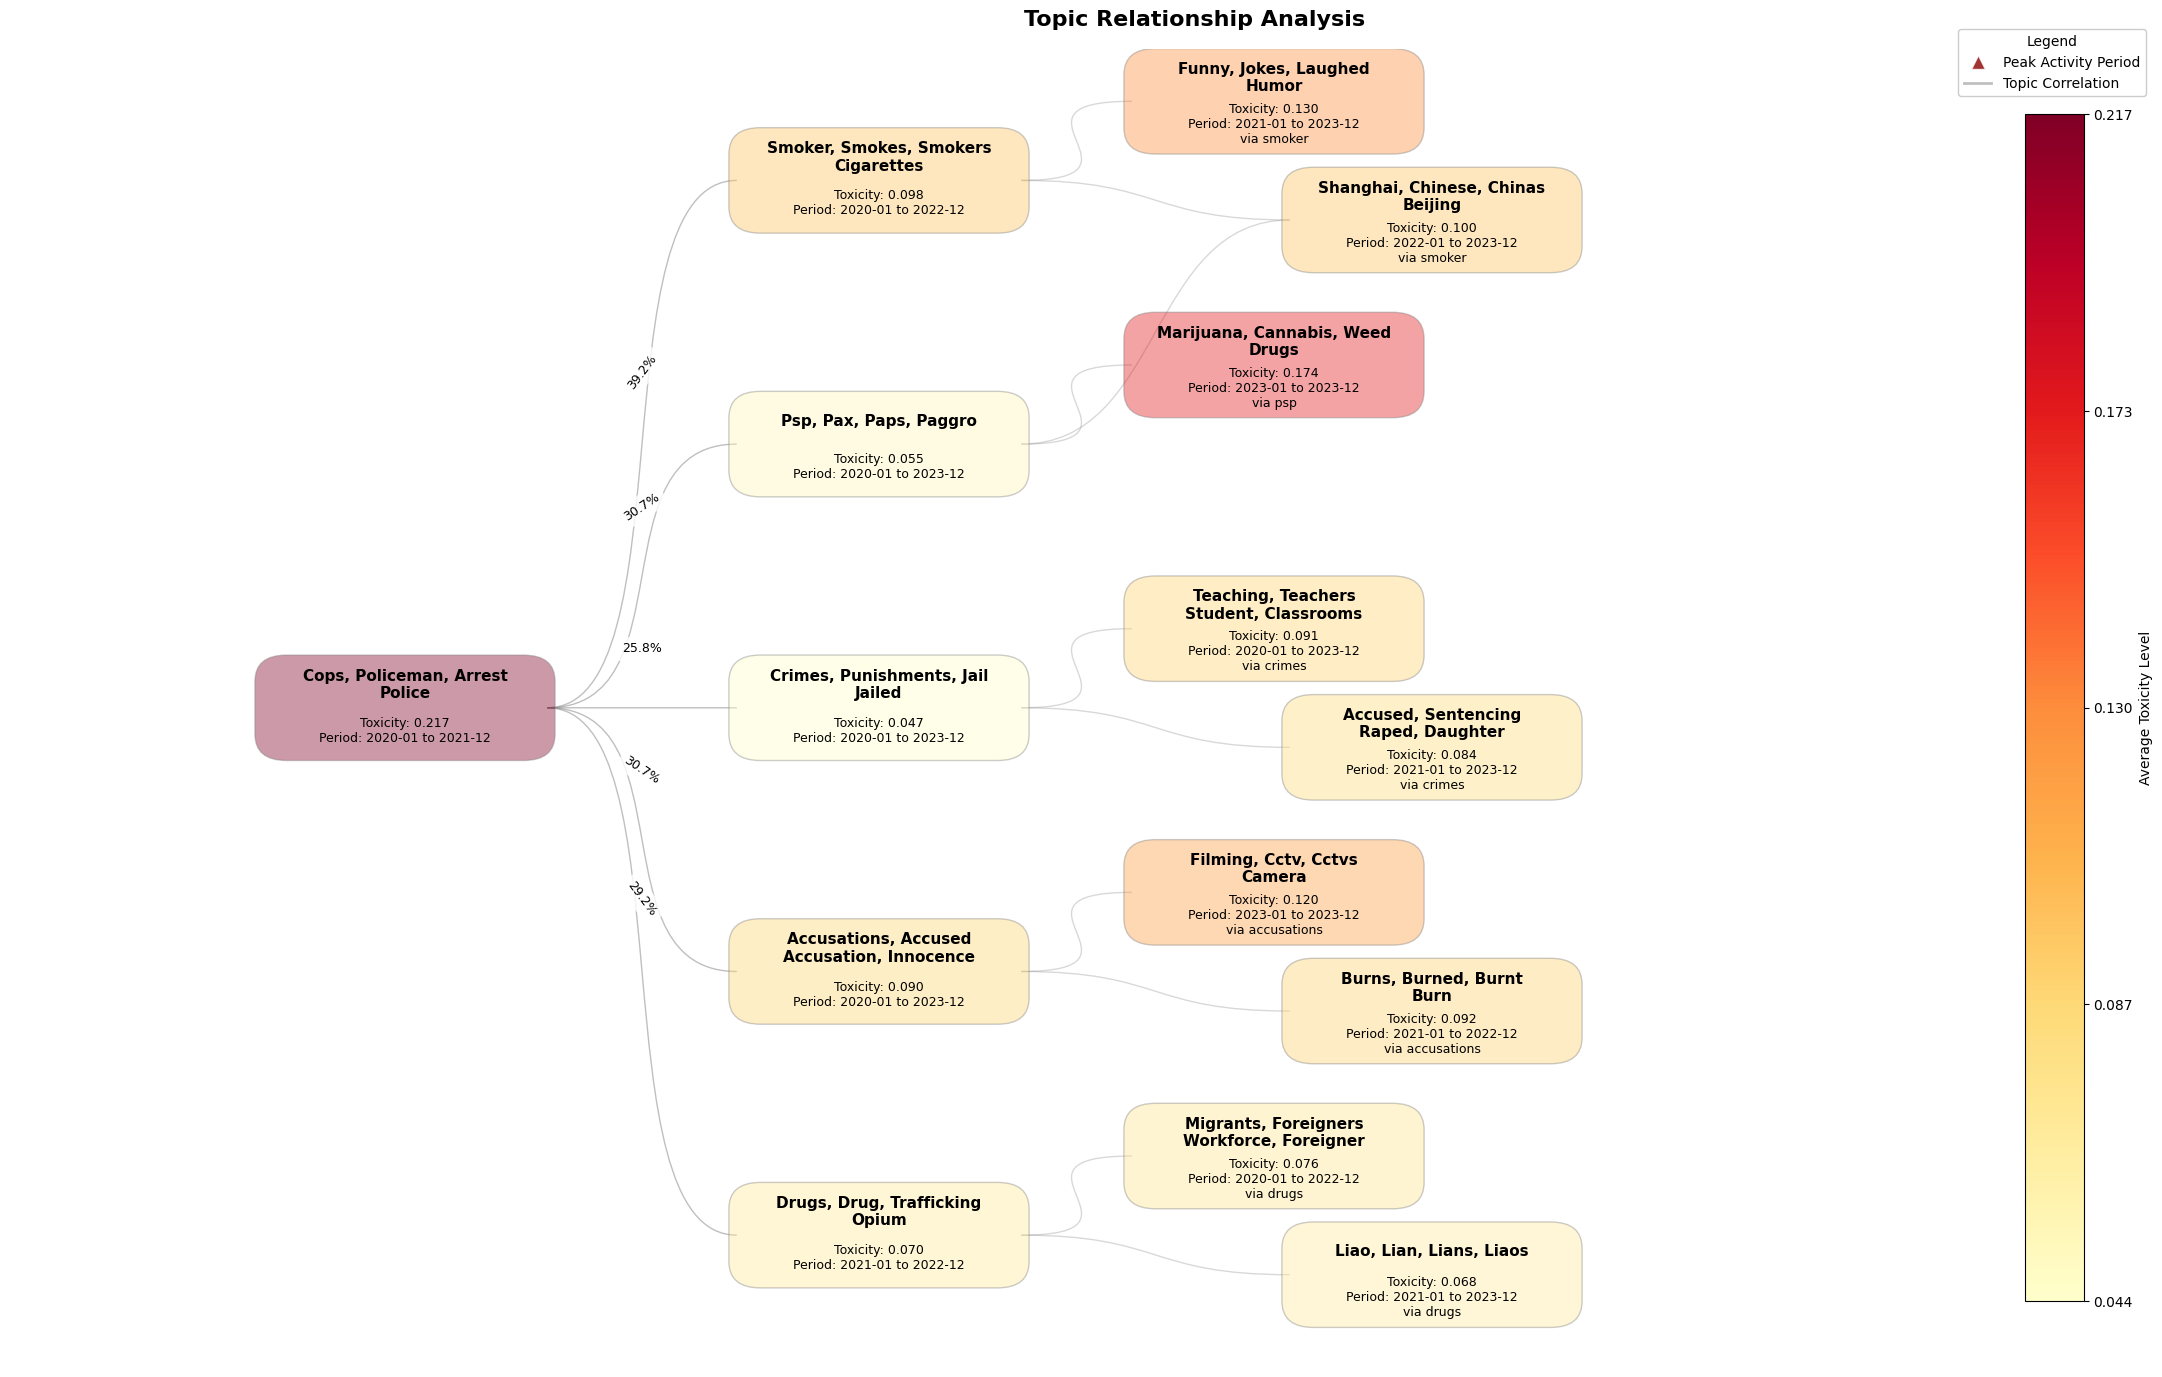

In [172]:
create_tree_visualization(G, 99, cluster_processed, connections_99)

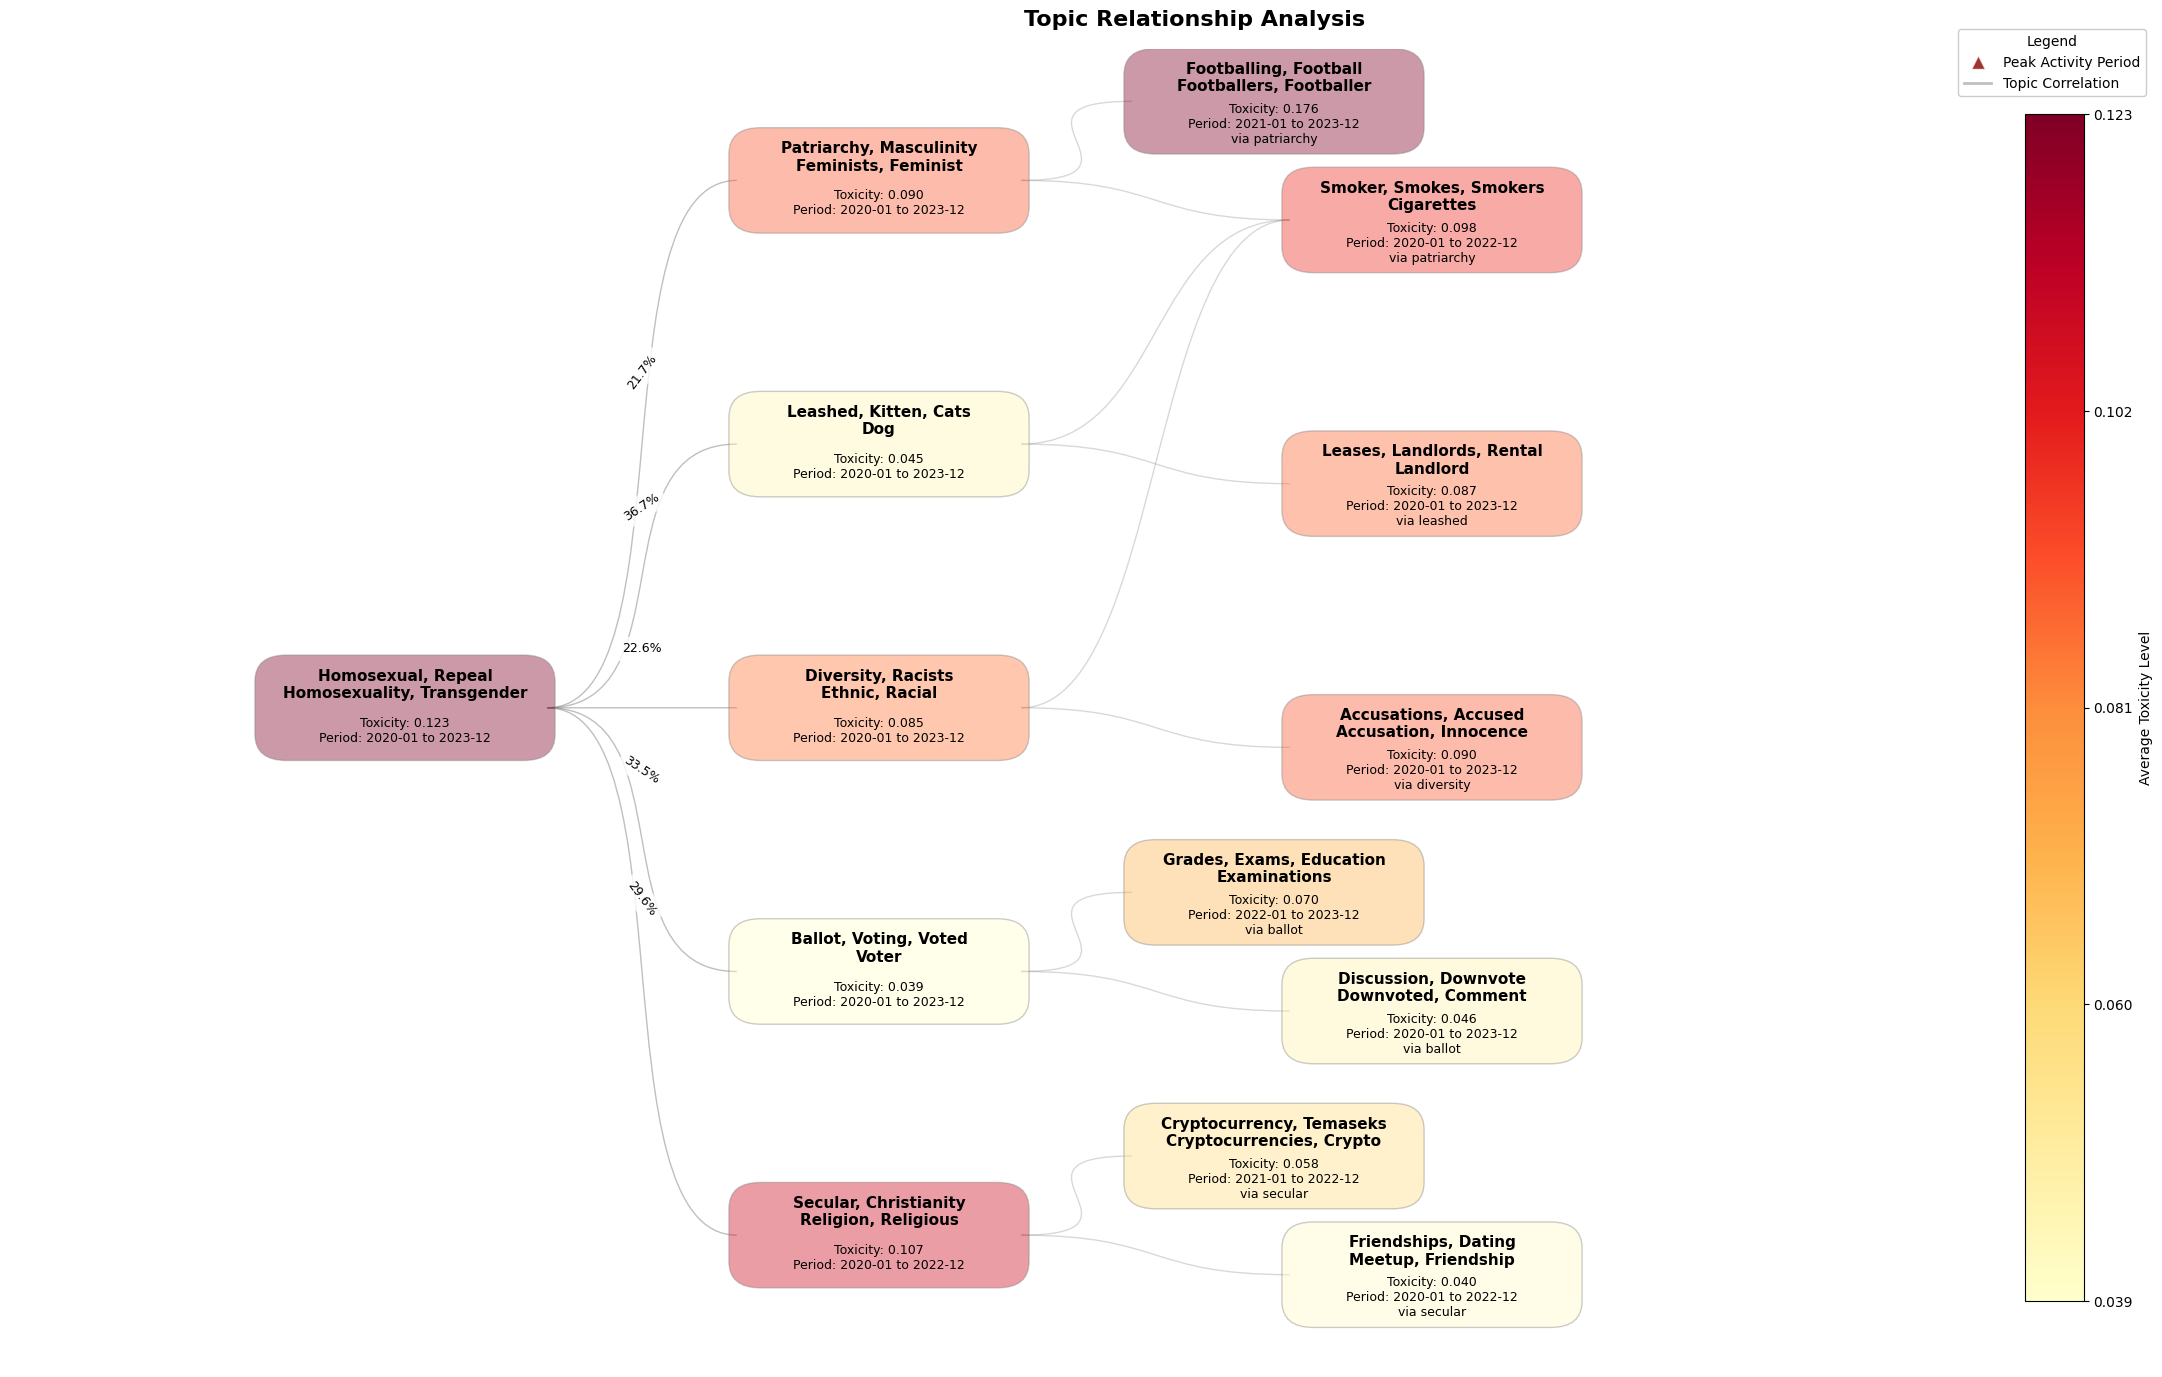

In [173]:
create_tree_visualization(G, 31, cluster_processed, connections_31)

In [133]:
def format_topic_name(keywords_list, max_words=3):
    """Format topic names in a business-friendly way showing up to max_words"""
    # Take first max_words keywords
    selected_keywords = keywords_list[:max_words]
    # Capitalize each word and join with commas
    return ', '.join(word.capitalize() for word in selected_keywords)

def aggregate_yearly_toxicity(toxicity_evolution):
    """Aggregate monthly toxicity data to yearly with max toxicity periods"""
    yearly_data = {}
    # Handle string representation if needed
    if isinstance(toxicity_evolution, str):
        toxicity_evolution = eval(toxicity_evolution)
        
    for year, months in toxicity_evolution.items():
        if isinstance(months, dict):  # Check if months is a dictionary
            toxicities = [data['avg_toxicity'] if isinstance(data, dict) else data 
                         for data in months.values()]
        else:
            toxicities = [months]  # If months is a single value
            
        yearly_data[year] = {
            'avg_toxicity': np.mean(toxicities),
            'max_toxicity': max(toxicities),
            'high_toxicity_months': sum(1 for t in toxicities if t > 0.15)
        }
    return yearly_data

def create_business_temporal_visualization(G, focus_node, cluster_df, connections):
    """Create business-friendly temporal visualization with enhanced readability"""
    # Get nodes to show
    nodes_to_show = [focus_node] + [conn['node_id'] for conn in connections[:5]]
    topics_data = cluster_df[cluster_df['cluster_id'].isin(nodes_to_show)]
    
    # Create figure with business-friendly size and proper spacing
    fig = plt.figure(figsize=(24, 14))
    ax = fig.add_subplot(111)
    
    # Initial spacing adjustments
    plt.subplots_adjust(left=0.25, right=0.85)  # Increase left margin, maintain right margin for colorbar
    
    # Increase spacing between topics
    y_pos = np.linspace(0, 12, len(nodes_to_show))  # More vertical space
    
    # Add background alternating bands for better readability
    for i in range(len(y_pos)):
        if i % 2 == 0:
            ax.axhspan(y_pos[i] - 0.8, y_pos[i] + 0.8, 
                      color='gray', alpha=0.05, zorder=1)
    
    # Draw main visualization with enhanced styling
    for idx, (node_id, y) in enumerate(zip(nodes_to_show, y_pos)):
        topic_data = cluster_df[cluster_df['cluster_id'] == node_id].iloc[0]
        yearly_toxicity = aggregate_yearly_toxicity(topic_data['toxicity_evolution'])
        
        # Enhanced baseline
        ax.plot([pd.to_datetime('2020-01-01'), pd.to_datetime('2024-01-01')],
                [y, y], color='grey', alpha=0.15, linestyle='-', linewidth=1.5, zorder=1)
        
        # Draw yearly blocks with business-friendly styling
        for year, data in yearly_toxicity.items():
            start_date = pd.to_datetime(f"{year}-01-01")
            end_date = pd.to_datetime(f"{int(year)+1}-01-01")
            
            ax.barh(y,
                   width=(end_date - start_date).days,
                   left=start_date,
                   height=1.2,  # Increased height for visibility
                   color=plt.cm.YlOrRd(data['avg_toxicity']),
                   alpha=0.5,
                   edgecolor='none',
                   zorder=2)
            
            # Enhanced high intensity indicators using standard marker
            if data['high_toxicity_months'] > 0:
                ax.scatter(start_date + pd.Timedelta(days=180), y,
                          marker='^', color='darkred', s=150, alpha=0.8,
                          zorder=3)
        
        # Enhanced topic labels and metrics
        if idx == 0:
            # Main topic with special formatting, showing 3 words
            ax.text(pd.to_datetime('2019-12-01'), y,
                    f"Primary Topic:\n{format_topic_name(G.nodes[node_id]['keywords'], 3)}",
                    va='center', ha='right', fontsize=14,
                    weight='bold', color='#2C3E50',
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.8),
                    zorder=4)
            # Metrics with business context
            ax.text(pd.to_datetime('2019-12-01'), y - 0.5,
                    f"Avg Toxicity: {topic_data['avg_toxicity']:.3f}",
                    va='center', ha='right', fontsize=12,
                    color='#566573',
                    zorder=4)
        else:
            # Related topics, showing 3 words
            ax.text(pd.to_datetime('2019-12-01'), y,
                    format_topic_name(G.nodes[node_id]['keywords'], 3),
                    va='center', ha='right', fontsize=12,
                    weight='bold', color='#2C3E50',
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.8),
                    zorder=4)
            # Enhanced metrics display with clearer correlation meaning
            conn = next(c for c in connections if c['node_id'] == node_id)
            ax.text(pd.to_datetime('2019-12-01'), y - 0.5,
                    f"Avg Toxicity: {topic_data['avg_toxicity']:.3f}\n" +
                    f"Correlation: {conn['temporal_sim']:.1%}",
                    va='center', ha='right', fontsize=11,
                    color='#566573',
                    zorder=4)
    
    ax.xaxis.set_major_locator(mdates.YearLocator(1))   # Show every year
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    # 3. Enhance grid visibility
    ax.grid(True, which='major', axis='x', 
            linestyle='--', 
            alpha=0.4,                  # Increase from 0.3
            color='gray')
    
    # Remove unnecessary elements
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Enhanced colorbar with proper spacing and no overlap
    norm = plt.Normalize(vmin=0, vmax=max(topics_data['avg_toxicity']))
    sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=norm)
    cbar = plt.colorbar(sm, ax=ax, pad=0.02)    # Add pad parameter
    cbar.set_label('Toxicity Level', fontsize=12, labelpad=20)         # Increase from 15
    cbar.ax.tick_params(labelsize=10, pad=8)  # Increased padding for tick labels
    
    # Enhanced legend with proper positioning
    legend_elements = [
        plt.Line2D([0], [0], marker='^', color='w', 
                  markerfacecolor='darkred', markersize=10, alpha=0.8,
                  label='High Intensity Period')
    ]
    ax.legend(handles=legend_elements, loc='upper right',
             bbox_to_anchor=(1.14, 1.04),  # Adjusted position
             fontsize=10)
    
    # Improved title and subtitle alignment
    fig.suptitle("Topic Relationship Trends Over Time", 
            x=0.5, y=0.92,          # Move title up slightly
            fontsize=16, 
            fontweight='bold', 
            color='#2C3E50',
            ha='center')
    
    # Add x-label with increased padding
    ax.set_xlabel("Year", fontsize=12, color='#2C3E50', labelpad=20)
    
    # Final layout adjustments in correct order
    plt.tight_layout()
    plt.subplots_adjust(left=0.30,      # Increase from 0.25 for longer labels
                        right=0.85,
                        top=0.90,        # Lower from 0.93 to give more space for titles
                        bottom=0.1)
    

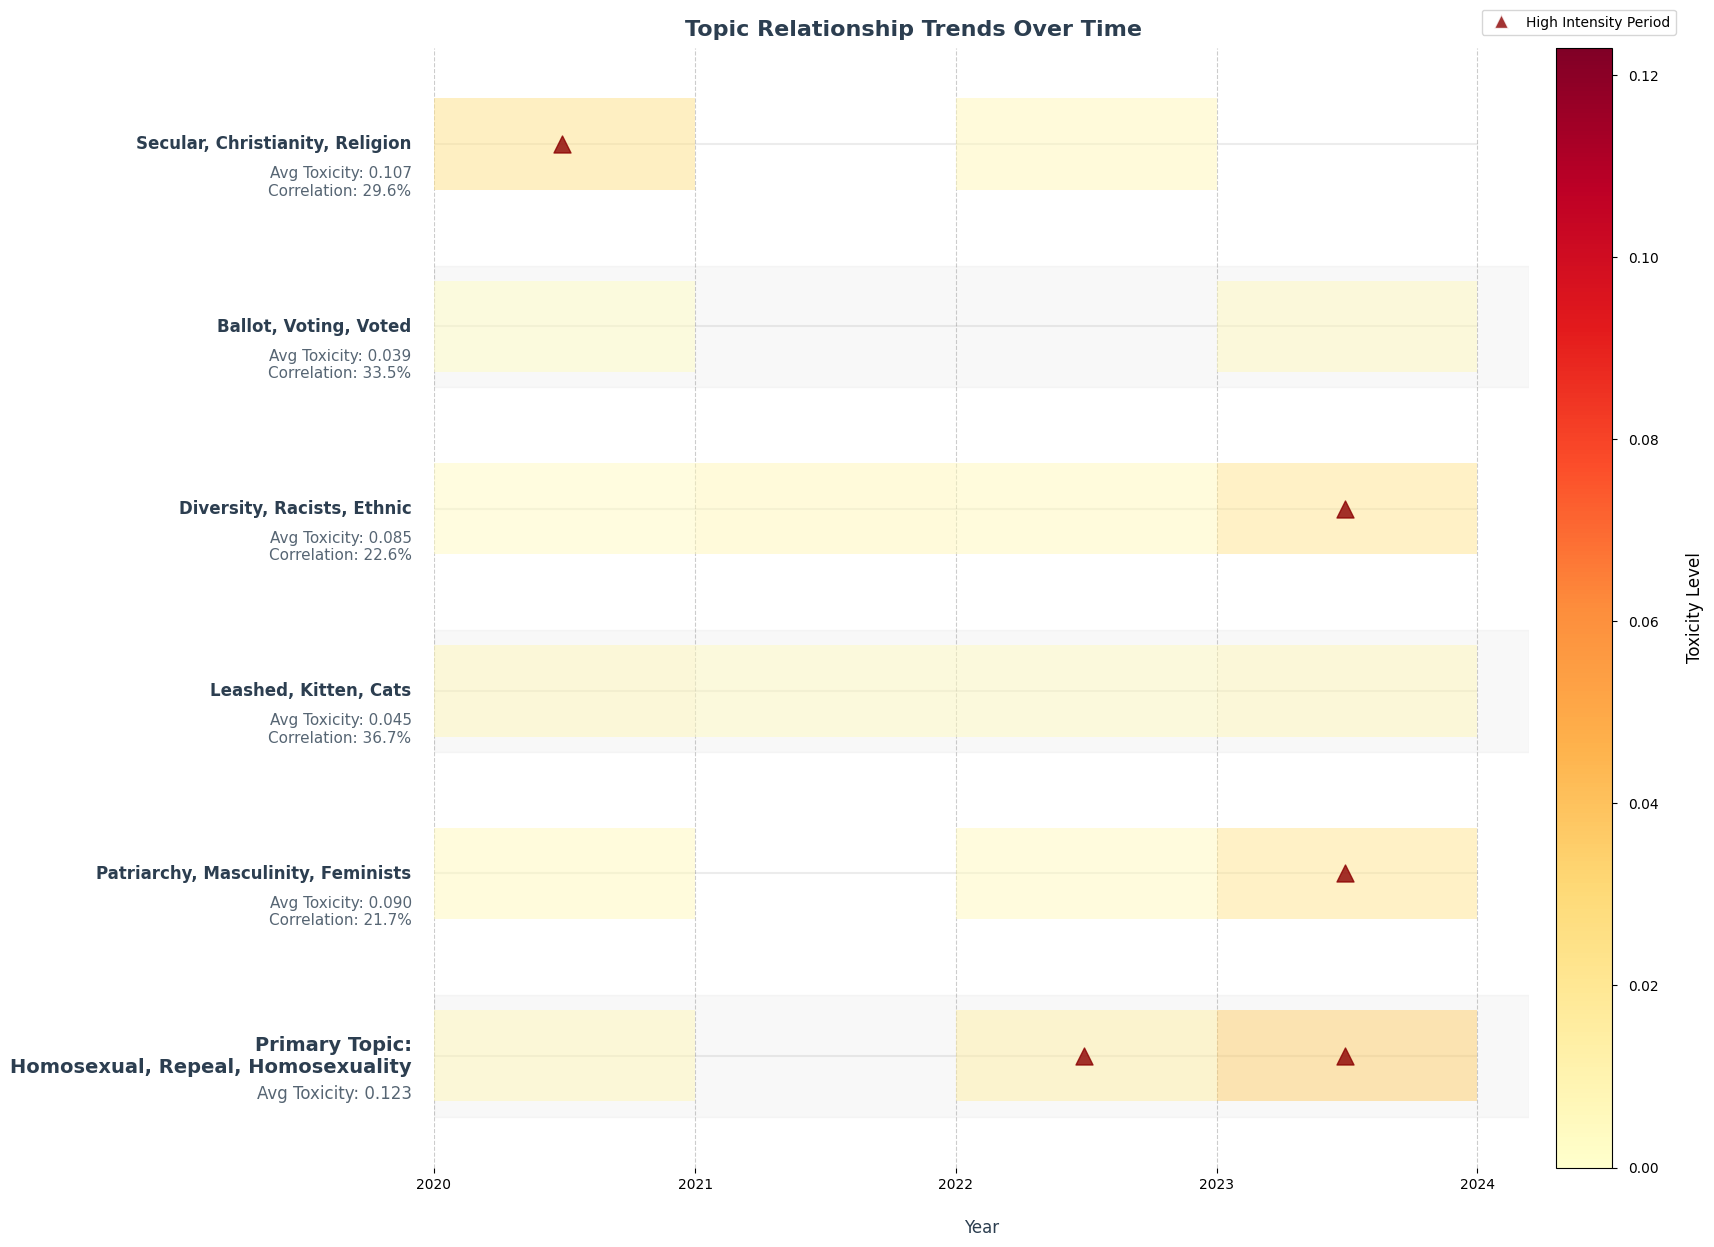

In [134]:
create_business_temporal_visualization(G, 31, cluster_processed, connections_31)

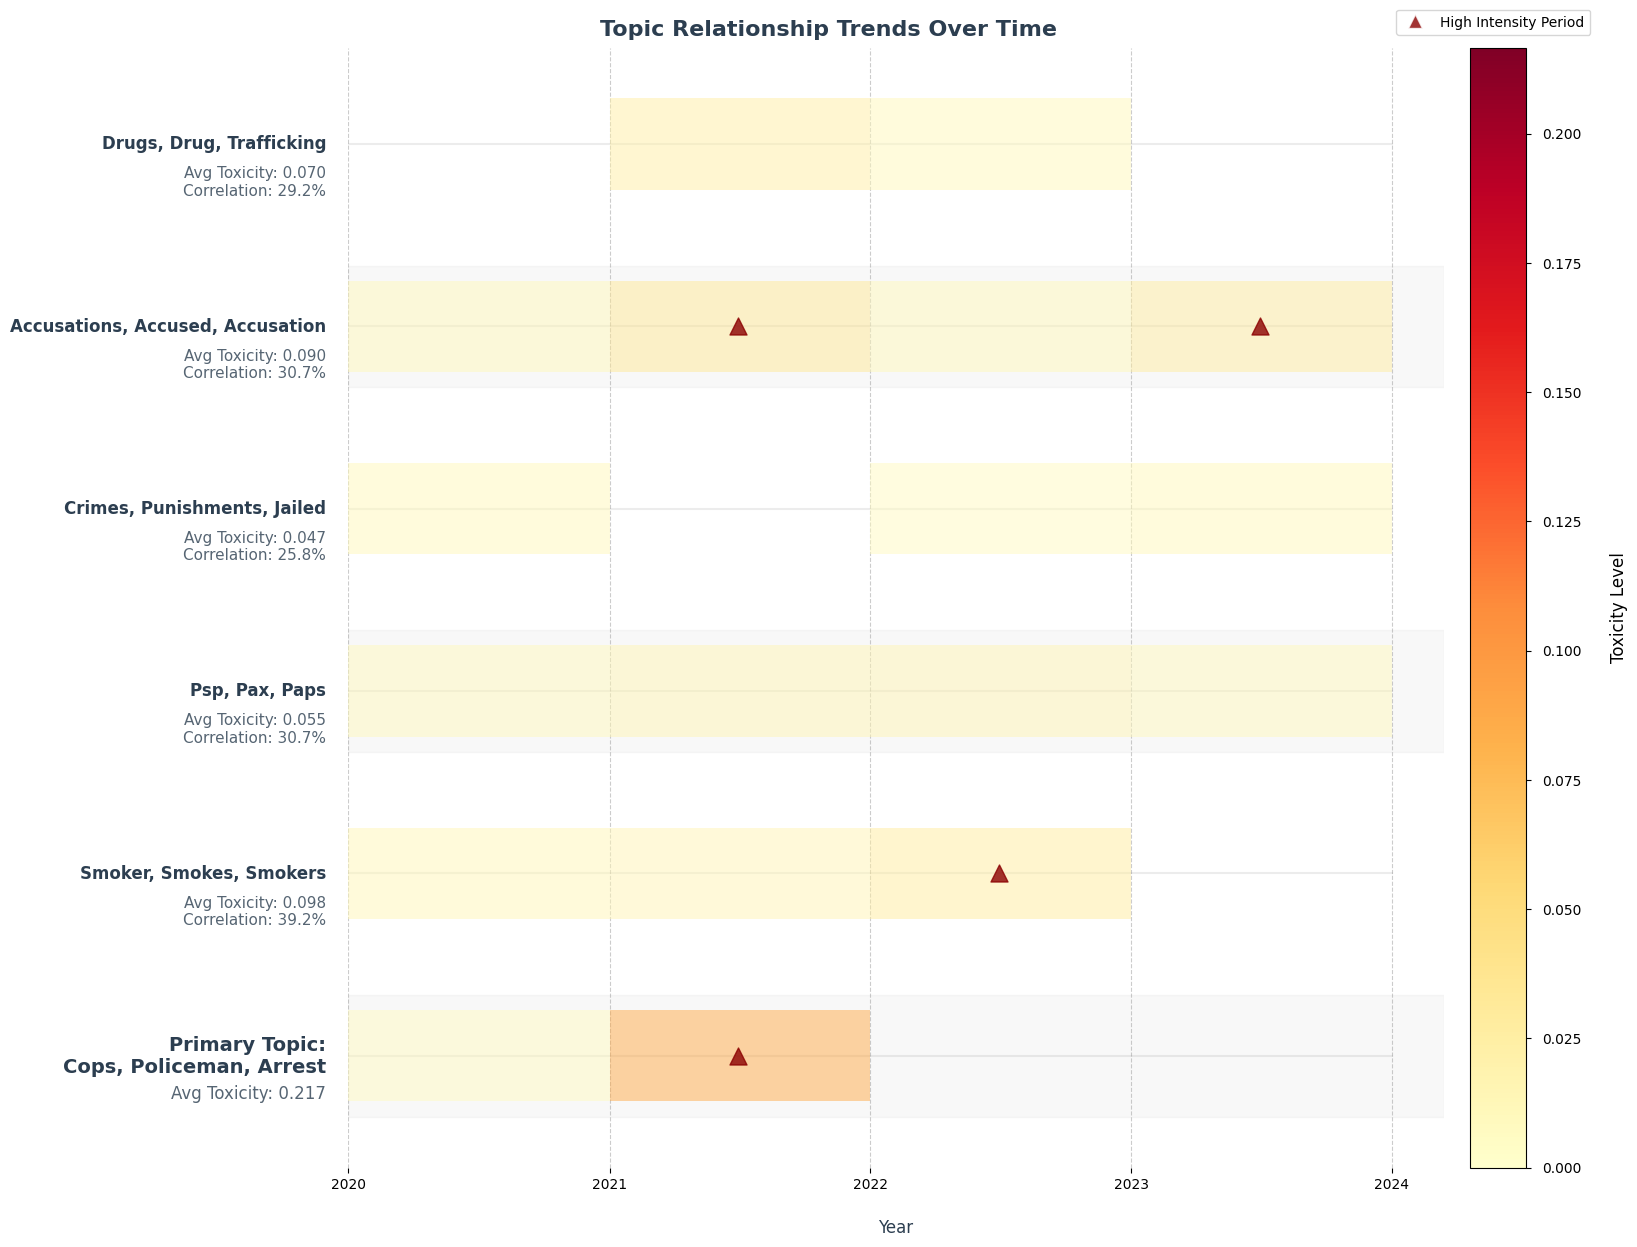

In [135]:
create_business_temporal_visualization(G, 99, cluster_processed, connections_99)

In [ ]:
def save_network_data(G, directory="network_data", filename="network_data.json"):
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Created directory: {directory}")
    
    # Create full file path
    filepath = os.path.join(directory, filename)
    
    # Convert NetworkX graph to a format suitable for visualization
    network_data = {
        "nodes": [],
        "edges": [],
        "metadata": {
            "num_nodes": G.number_of_nodes(),
            "num_edges": G.number_of_edges(),
            "density": nx.density(G),
            "avg_clustering": nx.average_clustering(G)
        }
    }
    
    # Add nodes with their attributes
    for node in G.nodes():
        node_data = {
            "id": str(node),
            "keywords": G.nodes[node].get('keywords', []),
            "posts": G.nodes[node].get('posts', 0),
            "toxicity": G.nodes[node].get('toxicity', 0)
        }
        network_data["nodes"].append(node_data)
    
    # Add edges with their attributes
    for u, v, data in G.edges(data=True):
        edge_data = {
            "source": str(u),
            "target": str(v),
            "weight": data.get('weight', 0),
            "keyword_sim": data.get('keyword_sim', 0),
            "temporal_sim": data.get('temporal_sim', 0),
            "toxicity_sim": data.get('toxicity_sim', 0)
        }
        network_data["edges"].append(edge_data)
    
    # Save to file
    with open(filepath, 'w') as f:
        json.dump(network_data, f)
    
    print(f"Network data saved to {filepath}")
    return network_data

In [ ]:
network_data = save_network_data(G, directory="../data")

Network data saved to ../data\network_data.json
